In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
from qiskit_aer import Aer, AerSimulator
from qiskit.compiler import transpile
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import matplotlib.pyplot as plt


Set the backend as the Aer Simulator and Create the Hamiltonian H = X₀X₁ + Y₀Y₁ + Z₀I₁

In [2]:
backend = AerSimulator()

XX = SparsePauliOp.from_list([("XX", 1.0)])
YY = SparsePauliOp.from_list([("YY", 1.0)])
ZI = SparsePauliOp.from_list([("ZI", 1.0)])
hamiltonian = XX + YY + ZI


Define the Ansatz 

In [3]:
ansatz = EfficientSU2(hamiltonian.num_qubits)

The parameters will be the same as the number of parameters in the Ansatz and optimizing using a Preset Pass Manager

In [4]:
num_params = ansatz.num_parameters
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
ansatz_isa = pm.run(ansatz)

Now define a function that returns the energy that we got from the estimator. Also generate random initial parameters

In [5]:
cost_history_dict = {
    "prev_vector": None,
    "iterations": 0,
    "history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
	pub = (ansatz, [hamiltonian], [params])
	result = estimator.run(pubs=[pub]).result()
	energy = result[0].data.evs[0]
	
	cost_history_dict["iterations"] += 1
	cost_history_dict["prev_vector"] = params
	cost_history_dict["history"].append(energy)
	print(f"Iterations. done: {cost_history_dict['iterations']} [Current cost: {energy}]")

	return energy


X = 2 * np.pi * np.random.random(num_params)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

Run the optimization with the estimator and print the costs

In [6]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 16000

    res = minimize(
        cost_func,
        X,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
    )

Iterations. done: 1 [Current cost: 0.08980688706955814]
Iterations. done: 2 [Current cost: 0.09455659021311164]
Iterations. done: 3 [Current cost: -1.5000937441409912]
Iterations. done: 4 [Current cost: -1.3511030560589963]
Iterations. done: 5 [Current cost: -0.87138303856009]
Iterations. done: 6 [Current cost: -0.5152802949815637]
Iterations. done: 7 [Current cost: -1.1742391100556215]
Iterations. done: 8 [Current cost: -1.0447472032997938]
Iterations. done: 9 [Current cost: -0.9796262733579151]
Iterations. done: 10 [Current cost: -1.6348353227923256]
Iterations. done: 11 [Current cost: -1.3964752202987312]
Iterations. done: 12 [Current cost: -1.4399725017186427]
Iterations. done: 13 [Current cost: -1.71883007312043]
Iterations. done: 14 [Current cost: -1.1731141803637273]
Iterations. done: 15 [Current cost: -1.7832010499343791]
Iterations. done: 16 [Current cost: -1.4688456971439285]
Iterations. done: 17 [Current cost: -0.3934129116930192]
Iterations. done: 18 [Current cost: -1.00787

Plot a graph of the results

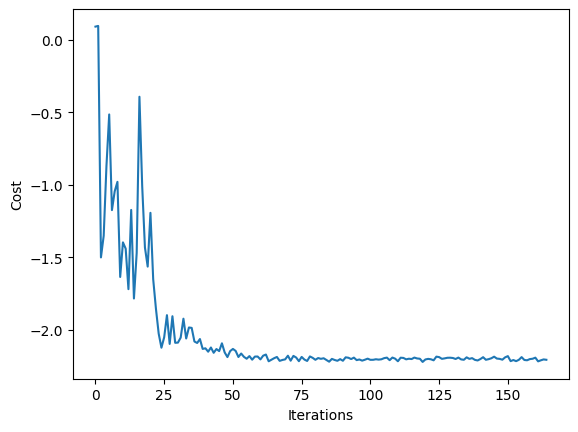

In [7]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iterations"]), cost_history_dict["history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

We plot the ground energy state gotten by the NumpyMinEigensolver and then compare it to the one we got by our iteration and plot the difference

In [8]:
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(hamiltonian)
print('Optimized ground state energy:', res.fun)
print('Exact ground state energy:', result.eigenvalue.real)
print('Energy Difference:', abs(result.eigenvalue.real - res.fun))

Optimized ground state energy: -2.205299668770702
Exact ground state energy: -2.236067977499788
Energy Difference: 0.03076830872908598


The VQE method has provided a reasonable approximation to the exact ground state energy, with a small error of around 0.0425.